In [1]:
import numpy as np
import os
import PIL
import glob
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new!
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import cv2

In [2]:
files = glob.glob('../data/dogs_cats/train/*.jpg')
cat_files = [x for x in files if 'cat' in x.split('/')[-1]]

In [3]:
src = Image.open(cat_files[0])

In [4]:
def get_discriminator():
    input_layer = Input((112, 112, 3))
    re_layer = keras.applications.ResNet50(include_top=False,
                                           weights = 'imagenet',
                                           input_shape = (112, 112, 3),
                                           pooling = 'avg')(input_layer)
    final_layer = Dense(1, activation='sigmoid')(re_layer)
    model = Model(inputs=input_layer, outputs = final_layer)
    return model

In [5]:
discriminator = get_discriminator()

2023-01-11 23:20:39.702077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 23:20:39.747788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 23:20:39.748273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 23:20:39.749656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [7]:
discriminator.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(),
    metrics = ['accuracy']
)

In [216]:
z_dimensions = 32

In [217]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = UpSampling2D((4, 4))(conv2)
    conv3 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv3)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    conv4 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv3)
    conv4 = BatchNormalization(momentum=0.9)(conv4)
    conv4 = Activation(activation='relu')(conv4)

    # Output layer
    image = Conv2D(3, kernel_size=1, padding='valid', 
                   activation='sigmoid')(conv4)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [218]:
generator = build_generator()

In [219]:
generator.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_6 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization_25 (Bat  (None, 3136)             12544     
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 3136)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                          

In [220]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [221]:
discriminator.trainable = False

In [222]:
pred = discriminator(img)

In [223]:
adversarial_model = Model(z, pred)

In [224]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=keras.optimizers.SGD(), 
                          metrics=['accuracy'])

In [225]:
pred

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model')>

In [226]:
adversarial_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32)]              0         
                                                                 
 model_10 (Functional)       (None, 112, 112, 3)       190019    
                                                                 
 model (Functional)          (None, 1)                 23589761  
                                                                 
Total params: 23,779,780
Trainable params: 183,603
Non-trainable params: 23,596,177
_________________________________________________________________


In [227]:
def train(epochs = 200, batch = 32, z_dim = z_dimensions):
    d_metrics, a_metrics = [], []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    current_batch_start = 0
    count = 0
    count_ = 0
    for i in range(epochs):
        real_imgs = np.zeros(shape=(batch, 112, 112, 3))
        real_img_start = 0
        for x_ in range(current_batch_start, current_batch_start + batch):
            img = cv2.imread(cat_files[x_])
            img = cv2.resize(img, (112, 112))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255
            real_imgs[real_img_start] = img
            real_img_start += 1
        # break

        # Generate random images
        random_latent = np.random.uniform(
                0.0, 1.0, size=(batch, z_dimensions)
            )
        fake_imgs = generator.predict(
            random_latent, verbose = 1
        )
        x = np.concatenate((real_imgs, fake_imgs))
        # return real_imgs

        y = np.ones([2 * batch, 1])
        y[batch:, :] = 0

        d_metrics.append(
            discriminator.train_on_batch(x, y)
        )

        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        noise = np.random.uniform(
            0.0, 1.0, size = [batch, z_dim]
        )
        y = np.ones([batch, 1])
        a_metrics.append(
            adversarial_model.train_on_batch(noise, y)
        )
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][0]
        if count_ % 100 == 0:
            print(count_)
        count_ += 1
    return a_metrics, d_metrics


In [263]:
a_metrics, d_metrics = train(epochs=3000)

1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 

In [258]:
noise = np.random.uniform(
    0.0, 1.0, size =[16, z_dimensions]
)

In [259]:
temp = generator.predict(noise)

1/1 [==============================] - 0s 21ms/step


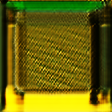

In [260]:
PIL.Image.fromarray((temp[0] * 255).astype(np.uint8))

In [262]:
d_metrics

[[1.2449462701624725e-05, 1.0],
 [1.096425148716662e-05, 1.0],
 [1.3680115444003604e-05, 1.0],
 [1.2114212040614802e-05, 1.0],
 [1.4628377357439604e-05, 1.0],
 [1.4802550140302628e-05, 1.0],
 [1.639892434468493e-05, 1.0],
 [1.504556985310046e-05, 1.0],
 [1.0879726687562652e-05, 1.0],
 [1.057084955391474e-05, 1.0],
 [9.04862281458918e-06, 1.0],
 [6.873338861623779e-06, 1.0],
 [1.2578919267980382e-05, 1.0],
 [9.43985469348263e-06, 1.0],
 [1.2807027815142646e-05, 1.0],
 [1.238404911418911e-05, 1.0],
 [1.5665122191421688e-05, 1.0],
 [1.439576044504065e-05, 1.0],
 [2.0542409401969053e-05, 1.0],
 [1.8801438272930682e-05, 1.0],
 [1.3950743777968455e-05, 1.0],
 [1.8896957044489682e-05, 1.0],
 [1.8098078726325184e-05, 1.0],
 [1.6873684216989204e-05, 1.0],
 [1.718918611004483e-05, 1.0],
 [2.0515308278845623e-05, 1.0],
 [1.7967062376555987e-05, 1.0],
 [1.3921460777055472e-05, 1.0],
 [1.9215060092392378e-05, 1.0],
 [1.3642620615428314e-05, 1.0],
 [1.5851910575293005e-05, 1.0],
 [1.1981352145085111